In [1]:
"""A hell draft notebook with raw data preprocessing.
I don't want to clean up this notebook untill it 
will be really needed:)
"""

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from flatlib.datetime import Datetime
from flatlib.geopos import GeoPos
from flatlib.chart import Chart
from flatlib import const
from flatlib import aspects

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

%matplotlib inline

/Users/denys/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [127]:
def process_raw_data():
    '''Загружаем сырые данные и делаем предобработку'''
    data_path = 'data/data-wiki/'
    data = pd.read_csv(data_path + 'agregated_dataset.csv', index_col=[0])
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    data['index'] = range(data.shape[0])
    data.set_index('index', inplace=True)

    # map sign with correct index number for sign
    signs = [(list(data[data['sign_code'] == i]['sign_code'].values)[0]) for i in range(1, 13)]
    animals = data['animal_name'].unique()
    num_to_animal = {k : v for k, v in enumerate(animals)}
    num_to_sign = {k : v for k, v in enumerate(signs)}

    data['east_horo'] = data['animal_name'].map(dict(map(reversed, num_to_animal.items())))
    data.drop(['animal_year_raper', 'sign_name', 'animal_name'], axis=1, inplace=True)
    data['category'] = data['category'].str.lower()

    # убрать повторы (если все колонки совпадают)
    duplicates_mask = data.duplicated(subset=['name', 'date', 'category'], keep='first')
    data.drop(data[duplicates_mask].index, axis=0, inplace=True)
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

    # создать колонку с датой в формате необходимой для астрологии
    data['astro_format'] = data['date'].apply(lambda x: '%d/%d/%d' % (x.date().year, x.date().month, x.date().day))
    data = data[data['category'] != 'muzika']

    # убираем дулирующую категорию
    data['index'] = range(data.shape[0])
    data.set_index('index', inplace=True)
    return data


def get_astr_features(bdate):
    '''базовая функа для расчета астрологии по заданной дате'''
    POS = GeoPos('55n45', '37e36')
    date = Datetime(bdate, '12:00', '+00:00')
    chart = Chart(date, POS, IDs=const.LIST_OBJECTS)
    return chart


def process_astro(data):
    '''Расчет астрологических признаков.
    Нужно еще расчитать объекты.'''
    # расчитываем название колонок для домов
    column_houses = ['h{num}_{attr}'.format(num=i, attr=j) for i in range(1, 13) for j in ['sign', 'signlon', 'size']]
    # расчитываем астрологические признаки для дома
    home_features = data['astro_format'].apply(lambda x: np.array([(i.sign, i.signlon, i.size) for i in get_astr_features(x).houses]).reshape(36)).values

    # расчитываем название колонок для углов
    column_angles = ['{angle}_{attr}'.format(angle=i, attr=j) for i in (['Asc', 'MC', 'Desc', 'IC']) for j in ['sign', 'signlon']]
    # расчитываем астрологические признаки для дома
    angles_features = data['astro_format'].apply(lambda x: np.array([(i.sign, i.signlon) for i in get_astr_features(x).angles]).reshape(4*2)).values

    # объеденить признкаи домов и углов а также названия колонок
    astro_feat = np.array([np.concatenate((home_features[i], angles_features[i])) for i in range(len(home_features))])
    columns = column_houses + column_angles

    # создаем датафрейм с астро признаками
    for i in range(len(columns)):
        dummy = []
        for j in range(len(astro_feat)):
            dummy.append(astro_feat[j][i])
        data[columns[i]] = dummy

    # приведем форматы
    mask_other = [i for i in data.columns if i.endswith('size') or i.endswith('signlon')]
    data[mask_other] = data[mask_other].astype('float64')
    return data


def prepaire_data_for_classification(dataframe):
    '''Готов данные для классификации, конвертируем номинальные в бинарные,
    удаляем лишние колонки и факторизуем признак категорий и разделяем х у.'''
    mask_sign = [i for i in dataframe.columns if i.endswith('sign')]
    
    
    dataframe['category_idx'], cat_idx = pd.factorize(dataframe['category'])
    dataframe.drop(labels=['category', 'date', 'name', 'sign_code', 'east_horo', 'astro_format'], axis=1, 
                         inplace=True)
    dataframe = pd.concat([dataframe, pd.get_dummies(dataframe['h1_sign'], prefix='h1_sign'),
                               pd.get_dummies(dataframe['h2_sign'], prefix='h2_sign'),
                               pd.get_dummies(dataframe['h3_sign'], prefix='h3_sign'),
                               pd.get_dummies(dataframe['h4_sign'], prefix='h4_sign'),
                               pd.get_dummies(dataframe['h5_sign'], prefix='h5_sign'),
                               pd.get_dummies(dataframe['h6_sign'], prefix='h6_sign'),
                               pd.get_dummies(dataframe['h7_sign'], prefix='h7_sign'),
                               pd.get_dummies(dataframe['h8_sign'], prefix='h8_sign'),
                               pd.get_dummies(dataframe['h9_sign'], prefix='h9_sign'),
                               pd.get_dummies(dataframe['h10_sign'], prefix='h10_sign'),
                               pd.get_dummies(dataframe['h11_sign'], prefix='h11_sign'),
                               pd.get_dummies(dataframe['h12_sign'], prefix='h12_sign'), 
                               pd.get_dummies(dataframe['Asc_sign'], prefix='Asc_sign'),
                               pd.get_dummies(dataframe['MC_sign'], prefix='MC_sign'),
                               pd.get_dummies(dataframe['Desc_sign'], prefix='Desc_sign'),
                               pd.get_dummies(dataframe['IC_sign'], prefix='IC_sign')],
                                axis=1)

    dataframe.drop(labels=dataframe[mask_sign], axis=1, inplace=True)
    num_to_cat = {k:v for k, v in enumerate(cat_idx)}
    y = dataframe['category_idx']
    y = pd.DataFrame(y.values, columns=['cat_idx'])
    y['cat_name'] = y['cat_idx'].map(num_to_cat)
    category_mask = [i for i in dataframe.columns if (i.startswith('category_')) & (i != 'category_idx')]
    
    dataframe.reset_index(drop=True, inplace=True)
    y = pd.concat([y, dataframe[category_mask]], axis=1)
    
    dataframe.drop(labels=category_mask, axis=1, inplace=True)
    # уберем из выборки целевой признак 
    dataframe.drop(labels='category_idx', axis=1, inplace=True)
    return dataframe, y, cat_idx

1. Функция рассчета признаков по дате
2. Функци разбиения на бинарные метки.

Для натальной карты мы нужны планеты (какие планеты в зодиаках), дома (какие планеты в домах), аспекты, 

Write a function to generate all geatures from singl date

In [123]:
# date = '1988/10/17'
# chart = get_astr_features(date)

# column_object = [i.id for i in a.objects]
# column_object = [i.replace(' ', '_') for i in column_object]
# objects = np.array([i.sign for i in chart.objects]).reshape(1, -1)

# column_houses = ['h{num}_{attr}'.format(num=i, attr=j) for i in range(1, 13) for j in ['sign']]
# home_features = [i.sign for i in chart.houses]

# data = pd.DataFrame(objects, columns=column_object)

# data = pd.concat([data, pd.get_dummies(data['Sun'], prefix='Sun'),
#                                pd.get_dummies(data['Moon'], prefix='Moon'),
#                                pd.get_dummies(data['Mercury'], prefix='Mercury'),
#                                pd.get_dummies(data['Venus'], prefix='Venus'),
#                                pd.get_dummies(data['Mars'], prefix='Mars'),
#                                pd.get_dummies(data['Jupiter'], prefix='Jupiter'),
#                                pd.get_dummies(data['Saturn'], prefix='Saturn'),
#                                pd.get_dummies(data['Uranus'], prefix='Uranus'),
#                                pd.get_dummies(data['Neptune'], prefix='Neptune'),
#                                pd.get_dummies(data['Pluto'], prefix='Pluto'),
#                                pd.get_dummies(data['Chiron'], prefix='Chiron'),
#                                pd.get_dummies(data['North_Node'], prefix='North_Node'), 
#                                pd.get_dummies(data['South_Node'], prefix='South_Node'),
#                                pd.get_dummies(data['Syzygy'], prefix='Syzygy'),
#                                pd.get_dummies(data['Pars_Fortuna'], prefix='Pars_Fortuna')],
#                                axis=1)

***New proccessing pipeline***

In [225]:
d = pd.read_csv('sport_data.csv')[['name', 'category', 'astro_format']]

In [229]:
def process_astro(data):
    '''Расчет астрологических признаков.
    Нужно еще расчитать объекты.'''
    chart = get_astr_features(data['astro_format'][0])
    column_object = [i.id for i in chart.objects]
    column_object = [i.replace(' ', '_') for i in column_object]
    # objects = np.array([i.sign for i in chart.objects]).reshape(1, -1)
    object_features = data['astro_format'].apply(lambda x: np.array([i.sign for i in get_astr_features(x).objects]
                                                                   ).reshape(15)).values

    dummy = np.chararray(shape=(len(object_features), 15), itemsize=15, unicode=True)
    for i in range(object_features.shape[0]): dummy[i, :] = object_features[i]
        
    return pd.concat([data, pd.DataFrame(data=dummy, columns=column_object)], axis=1)

In [223]:
data = process_astro(d)

In [235]:
labels, cat_idx = pd.factorize(data['category'])
data.drop(labels=['name', 'category', 'astro_format'], axis=1, inplace=True)

In [237]:
data = pd.concat([data, pd.get_dummies(data['Sun'], prefix='Sun'),
                               pd.get_dummies(data['Moon'], prefix='Moon'),
                               pd.get_dummies(data['Mercury'], prefix='Mercury'),
                               pd.get_dummies(data['Venus'], prefix='Venus'),
                               pd.get_dummies(data['Mars'], prefix='Mars'),
                               pd.get_dummies(data['Jupiter'], prefix='Jupiter'),
                               pd.get_dummies(data['Saturn'], prefix='Saturn'),
                               pd.get_dummies(data['Uranus'], prefix='Uranus'),
                               pd.get_dummies(data['Neptune'], prefix='Neptune'),
                               pd.get_dummies(data['Pluto'], prefix='Pluto'),
                               pd.get_dummies(data['Chiron'], prefix='Chiron'),
                               pd.get_dummies(data['North_Node'], prefix='North_Node'), 
                               pd.get_dummies(data['South_Node'], prefix='South_Node'),
                               pd.get_dummies(data['Syzygy'], prefix='Syzygy'),
                               pd.get_dummies(data['Pars_Fortuna'], prefix='Pars_Fortuna')],
                               axis=1)

data.drop(labels=data.iloc[:, :16], axis=1, inplace=True)

***Write fucntion for binary separate one class***

In [326]:
from sklearn.metrics import precision_score, recall_score, f1_score

new_labels = np.zeros((len(labels)))
new_labels[labels==3] = 1
new_labels[labels!=3] = 0

x_train, x_val, y_train, y_val = train_test_split(data, new_labels, test_size=0.33, random_state=17)

0.977983575048
Точность - 0.012987
Полнота - 0.003300
F1 - 0.005263


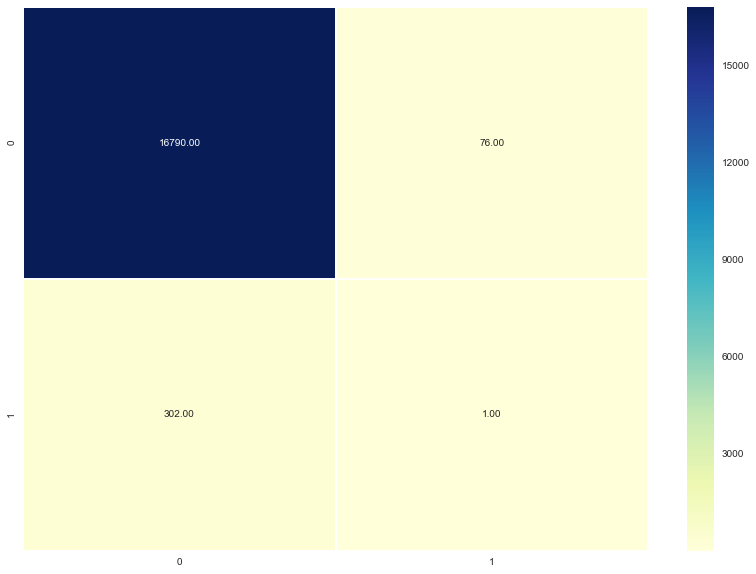

In [327]:
forest = RandomForestClassifier(n_estimators=200).fit(x_train, y_train)
predict = forest.predict(x_val)
print(accuracy_score(y_val, predict))
print('Точность - %f' % precision_score(y_val, predict))
print('Полнота - %f' % recall_score(y_val, predict))
print('F1 - %f' % f1_score(y_val, predict))

cm = confusion_matrix(y_val, predict)
plt.figure(figsize=(14, 10));
sns.heatmap(cm, annot=True, lw=1, cmap='YlGnBu', fmt='.2f');

In [329]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')

In [330]:
print(np.bincount(y_train)[1] / np.bincount(y_train)[0])
print(np.bincount(y_val)[1] / np.bincount(y_val)[0])

0.0179301483472
0.0179651369619


In [332]:
x_train.head()

,Sun_Aquarius,Sun_Aries,Sun_Cancer,Sun_Capricorn,Sun_Gemini,Sun_Leo,Sun_Libra,Sun_Pisces,Sun_Sagittarius,Sun_Scorpio,...,Pars_Fortuna_Cancer,Pars_Fortuna_Capricorn,Pars_Fortuna_Gemini,Pars_Fortuna_Leo,Pars_Fortuna_Libra,Pars_Fortuna_Pisces,Pars_Fortuna_Sagittarius,Pars_Fortuna_Scorpio,Pars_Fortuna_Taurus,Pars_Fortuna_Virgo
47530,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29190,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7378,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
15472,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40509,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [128]:

# sport_cat = ['sport_footbolist', 'hokeist', 'shahmatisty', 'legko_atlety', 'basketballs', 'boxers', 'tenisisti', 
#             'figuristi', 'velogonshiki', 'sport_gonshiki']
# sport = raw_data[raw_data['category'].isin(sport_cat)]
# sport['date'] = pd.to_datetime(sport['date'])
# sport['idx'] = np.arange(len(sport))
# sport.set_index('idx', inplace=True)

# # объеденим футбол, хокей и баскетбол
# sport.loc[sport[sport['category'].isin(['sport_footbolist', 'hokeist', 'basketballs'])].index, 'category'] = 'fhb'

# # удалить прямые дубли
# to_delete = sport[sport.duplicated(subset=['name', 'date', 'category'])].index
# sport.drop(labels=to_delete, axis=0, inplace=True)

In [129]:
# # закодируем професии
# sport = pd.concat([sport, pd.get_dummies(sport['category'], prefix='category')], axis=1)

# # найдем индексы всех дубликатов по имени, но категории разные!
# all_duplicates_idx = sport.duplicated(subset=['date', 'sign_code', 'name'], keep=False)

# # найдем уникальные имена среди дубликатов
# unique_names = sport[all_duplicates_idx]['name'].unique()
# category_mask = [i for i in sport.columns if i.startswith('category_')]

# # пройтись по всем уникальным именнам в списке дублей
# for i in tqdm(range(len(unique_names))):
#     # датафрейм одного дубля (нам нужны его професии)
#     person = sport[sport['name'] == unique_names[i]]

#     # перезаписываем значение вектора професий для первого индекса в списке
#     sport.loc[person.index[0], category_mask] = person[category_mask].values.sum(axis=0)

#     # формируем списко индексов последующих дублей и удаляем эти индесы из дф
#     person_idx_to_delete = person.index[1:]
#     sport.drop(person_idx_to_delete, axis=0, inplace=True)
    
# sport.to_csv('sport_data.csv')

In [130]:
# data = raw_data[~raw_data['category'].isin(sport_cat)]
# data['date'] = pd.to_datetime(data['date'])
# data['idx'] = np.arange(len(data))
# data.set_index('idx', inplace=True)

In [131]:
# # закодируем професии
# data = pd.concat([data, pd.get_dummies(data['category'], prefix='category')], axis=1)

# # найдем индексы всех дубликатов по имени, но категории разные!
# all_duplicates_idx = data.duplicated(subset=['date', 'sign_code', 'name'], keep=False)

# # найдем уникальные имена среди дубликатов
# unique_names = data[all_duplicates_idx]['name'].unique()
# category_mask = [i for i in data.columns if i.startswith('category_')]

# # пройтись по всем уникальным именнам в списке дублей
# for i in tqdm(range(len(unique_names))):
#     # датафрейм одного дубля (нам нужны его професии)
#     person = data[data['name'] == unique_names[i]]

#     # перезаписываем значение вектора професий для первого индекса в списке
#     data.loc[person.index[0], category_mask] = person[category_mask].values.sum(axis=0)

#     # формируем списко индексов последующих дублей и удаляем эти индесы из дф
#     person_idx_to_delete = person.index[1:]
#     data.drop(person_idx_to_delete, axis=0, inplace=True)
    
# data.to_csv('data.csv')

In [132]:
sport = pd.read_csv('sport_data.csv', index_col='idx')
data = pd.read_csv('data.csv', index_col='idx')

x_sport, y_sport, sport_idx = prepaire_data_for_classification(sport)
x_data, y_data, data_idx = prepaire_data_for_classification(data)

x_train, x_val, y_train, y_val = train_test_split(x_sport, y_sport['cat_idx'], test_size=0.33, random_state=17)

In [147]:
from sklearn.linear_model import LogisticRegression

0.736501834702


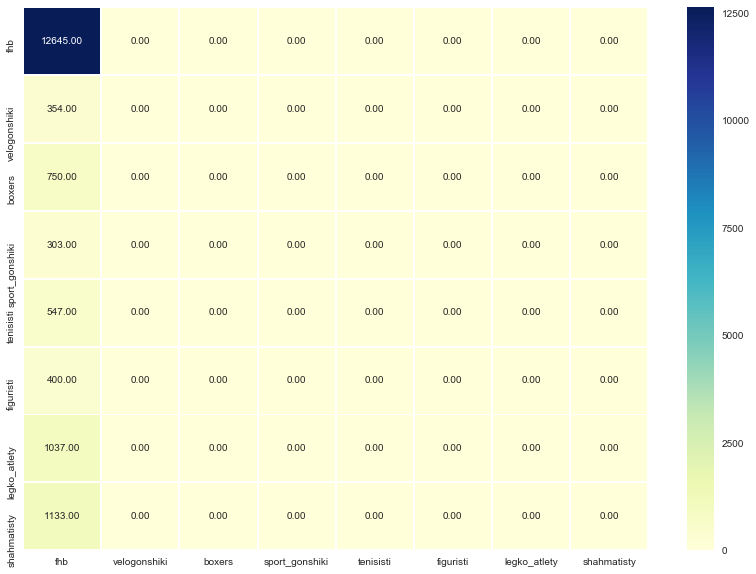

In [148]:
forest = RandomForestClassifier().fit(x_train, y_train)
logres = LogisticRegression().fit(x_train, y_train)
predict = logres.predict(x_val)
print(accuracy_score(y_val, predict))



cm = confusion_matrix(y_val, predict)
plt.figure(figsize=(14, 10));
sns.heatmap(cm, annot=True, lw=1, cmap='YlGnBu', fmt='.2f', xticklabels=sport_idx.values, yticklabels=sport_idx.values);
# tree_params = {'max_depth' : [4, 5, 6, 10],
#               'max_features' : [3, 4, 5, 6, 7]}
# greed_tree = GridSearchCV(tree, tree_params, cv=5)
# greed_tree.fit(x_train, y_train)
# print(greed_tree.best_params_, greed_tree.best_score_)

# predict = greed_tree.best_estimator_.predict(x_val)

In [35]:
tree = DecisionTreeClassifier().fit(x_train, y_train)
predict = tree.predict(x_val)


cm = confusion_matrix(y_val, predict)
cm_norm_rows = cm / np.sum(cm, axis=1).reshape(-1, 1)
plt.figure(figsize=(14, 10));
sns.heatmap(cm, annot=True, lw=1, cmap='YlGnBu', fmt='.2f', xticklabels=cat_idx.values, yticklabels=cat_idx.values);

accuracy_score(y_val, predict)


tree_params = {'max_depth' : [4, 5, 6, 10],
              'max_features' : [3, 4, 5, 6, 7]}
greed_tree = GridSearchCV(tree, tree_params, cv=5)
greed_tree.fit(x_train, y_train)
print(greed_tree.best_params_, greed_tree.best_score_)

predict = greed_tree.best_estimator_.predict(x_val)

In [408]:
duplicate_idx = [i for i, j in enumerate(sport.duplicated(subset=['date']).astype('int')) if j == 1]
duplicate_rows = [i for i, j in enumerate(sport.duplicated().astype('int')) if j == 1]

In [36]:
tree = DecisionTreeClassifier(max_depth=5, max_features=6).fit(x_train, y_train)
predict = tree.predict(x_val)


tree_params = {'max_depth' : [4, 5, 6, 10],
              'max_features' : [3, 4, 5, 6, 7]}
greed_tree = GridSearchCV(tree, tree_params, cv=5)
greed_tree.fit(x_train, y_train)
greed_tree.best_params_, greed_tree.best_score_

predict = greed_tree.best_estimator_.predict(x_val)


cm = confusion_matrix(y_val, predict)
cm_norm_rows = cm / np.sum(cm, axis=1).reshape(-1, 1)
plt.figure(figsize=(14, 10));
sns.heatmap(cm, annot=True, lw=1, cmap='YlGnBu', vmax=100, xticklabels=sport_cat, yticklabels=sport_cat);

In [258]:
precision_score(y_val, predict, average='weighted'), recall_score(y_val, predict, average='weighted'), \
accuracy_score(y_val, predict)

accuracy_score(y_val, predict)

y_sport.groupby(by='cat_name').count().sort_values(by=['cat_idx'], ascending=False)

(0.3631770006111486, 0.60264168509251714, 0.60264168509251714)

In [557]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

# стандартизуем все признаки
scaler = StandardScaler()
x_train_stand = scaler.fit_transform(x_train)

log_res = linear_model.LogisticRegression()
log_res.fit(x_train_stand, y_train)
cross_val_score(log_res, x_train_stand, y_train, cv=5, verbose=1)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


array([ 0.26208791,  0.24958769,  0.23542354,  0.2383049 ,  0.24352617])

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(analys_category, y)

23000

In [83]:
# закодируем професии
data = pd.concat([data, pd.get_dummies(data['category'], prefix='category')], axis=1)
# найдем индексы всех дубликатов по имени, но категории разные!
all_duplicates_idx = data.duplicated(subset=['date', 'sign_code', 'name'], keep=False)
# найдем уникальные имена среди дубликатов
unique_names = data[all_duplicates_idx]['name'].unique()
category_mask = [i for i in data.columns if i.startswith('category_')]

print('У нас - {} человек с больше чем одной професией'.format(data.duplicated(subset=['date', 'sign_code', 'name'], 
                                                                               keep=False).sum()))

У нас - 0 человек с больше чем одной професией


In [27]:
# пройтись по всем уникальным именнам в списке дублей
for i in tqdm(range(len(unique_names))):
    # датафрейм одного дубля (нам нужны его професии)
    person = data[data['name'] == unique_names[i]]

    # перезаписываем значение вектора професий для первого индекса в списке
    data.loc[person.index[0], category_mask] = person[category_mask].values.sum(axis=0)

    # формируем списко индексов последующих дублей и удаляем эти индесы из дф
    person_idx_to_delete = person.index[1:]
    data.drop(person_idx_to_delete, axis=0, inplace=True)

100%|██████████| 16642/16642 [34:20<00:00,  9.51it/s]


In [28]:
print('После обработки у нас - {} человек с больше чем одной професией'.format(
    data.duplicated(subset=['date', 'sign_code', 'name'], keep=False).sum()))

0

In [29]:
# сохраняем данные
# data.to_csv('category_procesed.csv')

# EDA

In [16]:
data = pd.read_csv('category_procesed.csv', index_col='index')
print('Повтором имен - %d' % (data['name'].duplicated().sum()))
# избавимся от категорий по которым мало наблюдений
data.head(1)

Повтором имен - 9


,name,date,category,sign_code,east_horo,astro_format,h1_sign,h1_signlon,h1_size,h2_sign,...,category_psihology,category_redaktory,category_scenaristy,category_serial_kilers,category_shahmatisty,category_skulptory,category_sport_footbolist,category_sport_gonshiki,category_tenisisti,category_velogonshiki
index,,,,,,,,,,,,,,,,,,,,,
0,"Абалаков, Виталий Михайлович",1906-01-13,engineer,1,0,1906/1/13,Cancer,7.979613,15.820846,Cancer,...,0,0,0,0,0,0,0,0,0,0


In [17]:
print('В оригинальном формате - %d категорий' % (len(data['category'].unique())))

В оригинальном формате - 47 категорий


In [23]:
# fig, axes = plt.subplots(ncols=4, nrows=7, figsize=(16, 25))
# for idx, feat in enumerate(numerical_features_mask):
#     sns.boxplot(x='category', y=feat, data=low_distance_category, ax=axes[int(idx / 4), idx % 4]);


# fig, axes = plt.subplots(ncols=4, nrows=7, figsize=(16, 25))
# for idx, feat in enumerate(numerical_features_mask):
#     sns.boxplot(x='category', y=feat, data=hight_distance_category, ax=axes[int(idx / 4), idx % 4]);

***ВЫВОД. По отдельности количественные признаки не имеют влияние на целевую переменную!***

In [555]:
# analys_category = data[data['category'].isin(['artisty', 'engineer', 'ekonomisty', 'perevodchiki', 
#                                               'pedagogy', 'painters'])]
# fig, axes = plt.subplots(ncols=4, nrows=7, figsize=(16, 25))
# fig.autofmt_xdate(rotation=90)
# for idx, feat in enumerate(numerical_features_mask):
#     sns.boxplot(x='category', y=feat, data=analys_category, ax=axes[int(idx / 4), idx % 4]);  

***ВЫВОД. Если анализировать сразу несколько категорий по некоторым признакам наблюдается диференциация!***

Я предпологаю что разница в значениях медианы по професиям говорит о том, что признак может быть использован
для прогноза целевой переменной!

In [556]:
# non_numerical_features = [i for i in data.columns if i.endswith('sign')]

# plt.figure(figsize=(16, 10))
# sns.heatmap(pd.crosstab(analys_category['category'], analys_category['h2_sign'], normalize='index'),
#            annot=True);

***Попробуем уменьшить размерность до двух и посмотреть будут ли выделяться класстеры.***

In [10]:
# Подготовка данных для уменьшения размерности
mask_sign = [i for i in data.columns if i.endswith('sign')]
mask_other = [i for i in data.columns if i.endswith('size') or i.endswith('signlon')]


analys_category['name_cat'], cat_idx = pd.factorize(analys_category['category'])
analys_category.drop(labels=['category', 'date', 'name', 'sign_code', 'east_horo', 'astro_format'], axis=1, inplace=True)
analys_category.drop(labels=[i for i in analys_category.columns if i.startswith('category')], axis=1, inplace=True)

In [11]:
analys_category = pd.concat([analys_category, pd.get_dummies(analys_category['h1_sign'], prefix='h1_sign'),
                               pd.get_dummies(analys_category['h2_sign'], prefix='h2_sign'),
                               pd.get_dummies(analys_category['h3_sign'], prefix='h3_sign'),
                               pd.get_dummies(analys_category['h4_sign'], prefix='h4_sign'),
                               pd.get_dummies(analys_category['h5_sign'], prefix='h5_sign'),
                               pd.get_dummies(analys_category['h6_sign'], prefix='h6_sign'),
                               pd.get_dummies(analys_category['h7_sign'], prefix='h7_sign'),
                               pd.get_dummies(analys_category['h8_sign'], prefix='h8_sign'),
                               pd.get_dummies(analys_category['h9_sign'], prefix='h9_sign'),
                               pd.get_dummies(analys_category['h10_sign'], prefix='h10_sign'),
                               pd.get_dummies(analys_category['h11_sign'], prefix='h11_sign'),
                               pd.get_dummies(analys_category['h12_sign'], prefix='h12_sign'), 
                               pd.get_dummies(analys_category['Asc_sign'], prefix='Asc_sign'),
                               pd.get_dummies(analys_category['MC_sign'], prefix='MC_sign'),
                               pd.get_dummies(analys_category['Desc_sign'], prefix='Desc_sign'),
                               pd.get_dummies(analys_category['IC_sign'], prefix='IC_sign')],
                                axis=1)

analys_category.drop(labels=analys_category[mask_sign], axis=1, inplace=True)

# уберем из выборки целевой признак 
y = analys_category['name_cat']
analys_category.drop(labels='name_cat', axis=1, inplace=True)

***Уменьшаем размерность признакового пространства***

In [43]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# стандартизуем все признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(analys_category)

# уменьшение размерности примерно 11 минут
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(X_scaled)

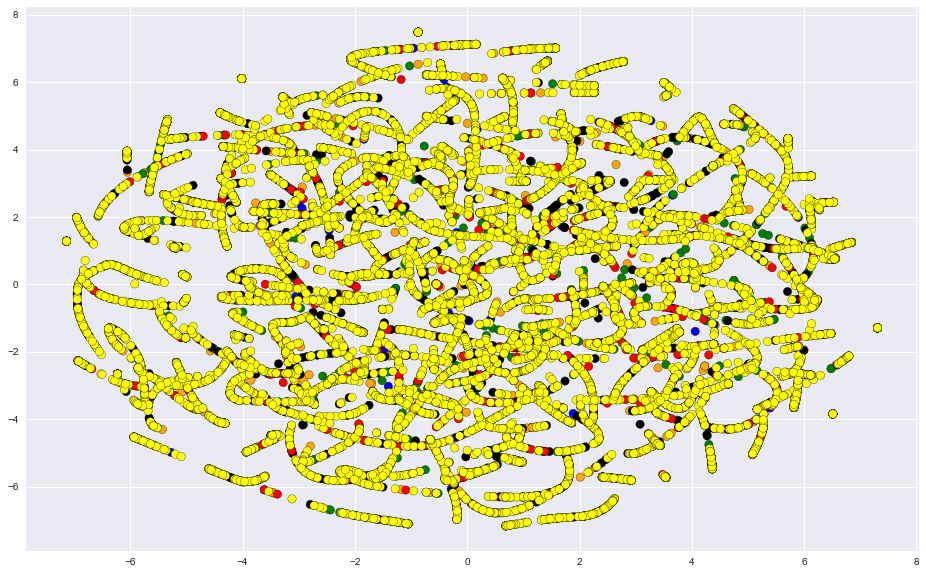

In [55]:
plt.figure(figsize=(16, 10))
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=y.map({0: 'blue', 1: 'orange', 2 : 'green', 3: 'black', 4: 'red', 
                                              5 : 'yellow'}), s=70, edgecolors='black');

***ВЫВОД. уменьшение размерности не дало жидаемый результат. Визуально кластеры не выделяются.***

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [71]:
# Попробуем класификацию на сжатых признаках
tree = DecisionTreeClassifier(random_state=10, max_depth=5)
tree.fit(tsne_representation, y)
print('Средняя доля правильных ответом - %f' % np.mean(cross_val_score(tree, tsne_representation, y, cv=5,  verbose=1)))
# print('При это случайная вероятность отгодать правильный ответ - %f' % (1 / len(data['category'].unique())))

Средняя доля правильных ответом - 0.487018


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


***Log Reg***

In [23]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

# стандартизуем все признаки
scaler = StandardScaler()
analys_category_standart = scaler.fit_transform(analys_category)

log_res = linear_model.LogisticRegression()
log_res.fit(analys_category_standart, y)
cross_val_score(log_res, analys_category_standart, y, cv=5, verbose=1)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished


array([ 0.48865031,  0.48865031,  0.48895028,  0.48895028,  0.48940092])

***SVM***

In [25]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(analys_category_standart, y)
cross_val_score(svm, analys_category_standart, y, cv=5, verbose=1)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.8min finished


array([ 0.48865031,  0.48865031,  0.48895028,  0.48895028,  0.48940092])

***NN***

In [28]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(50,), random_state=1)
clf.fit(analys_category_standart, y)
cross_val_score(clf, analys_category_standart, y, cv=3, verbose=1)

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.5s finished


array([ 0.48702374,  0.48858195,  0.48839352])

***XGBoost***

In [14]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(analys_category, y)

In [18]:
cross_val_score(model, analys_category, y, cv=5, verbose=1)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.3min finished


array([ 0.48957055,  0.48803681,  0.48956415,  0.48802947,  0.48970814])

***бустинг со страндартными параметрами практически не дал прироста к точности***

In [19]:
tree = DecisionTreeClassifier(random_state=10, max_depth=5)
tree.fit(analys_category, y)
cross_val_score(tree, analys_category, y, cv=5,  verbose=1)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished


array([ 0.48834356,  0.48834356,  0.48864334,  0.48802947,  0.48878648])

In [34]:
tree_params = {'max_depth' : [1, 2, 3, 4, 5, 6, 10, 15, 30, 50, 70],
              'max_features' : [2, 3, 4, 5, 6, 7]}
greed_tree = GridSearchCV(tree, tree_params, cv=6)
greed_tree.fit(analys_category, y)
greed_tree.best_params_, greed_tree.best_score_

{'max_depth': 1, 'max_features': 2}

In [36]:
forest = RandomForestClassifier(n_estimators=30, random_state=0)
forest.fit(analys_category, y)
# вытянем значение важности признаков
importances = forest.feature_importances_
importance_indexes = np.argsort(importances)[::-1]
print('Средняя доля правильных ответом - %f' % np.mean(cross_val_score(forest, analys_category, y, cv=5,  verbose=1)))
# print('При это случайная вероятность отгодать правильный ответ - %f' % (1 / len(data['category'].unique())))

Средняя доля правильных ответом - 0.240042


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.9s finished


In [37]:
tree_params = {'max_depth' : [1, 2, 3, 4, 5, 6, 10, 15, 30, 50, 70],
              'max_features' : [2, 3, 4, 5, 6, 7]}
greed_tree = GridSearchCV(forest, tree_params, cv=6)
greed_tree.fit(analys_category, y)
greed_tree.best_params_, greed_tree.best_score_, 

({'max_depth': 1, 'max_features': 2}, 0.38265422262690646)

***В общем видно что все алгоритмы не дают больше 48 процентов. Надо провести анализ ошибок и посмотреть
какие категории дают наиболшую ошибку. Также в запасе есть объединение нескольких професий!***

In [32]:
import mrstat
from scipy import stats

ModuleNotFoundError: No module named 'mrstat'

In [36]:
from mrstat import mrstat
table = analys_category.pivot_table(values='id',index=u'schtyp',columns=u'female',aggfunc='count')

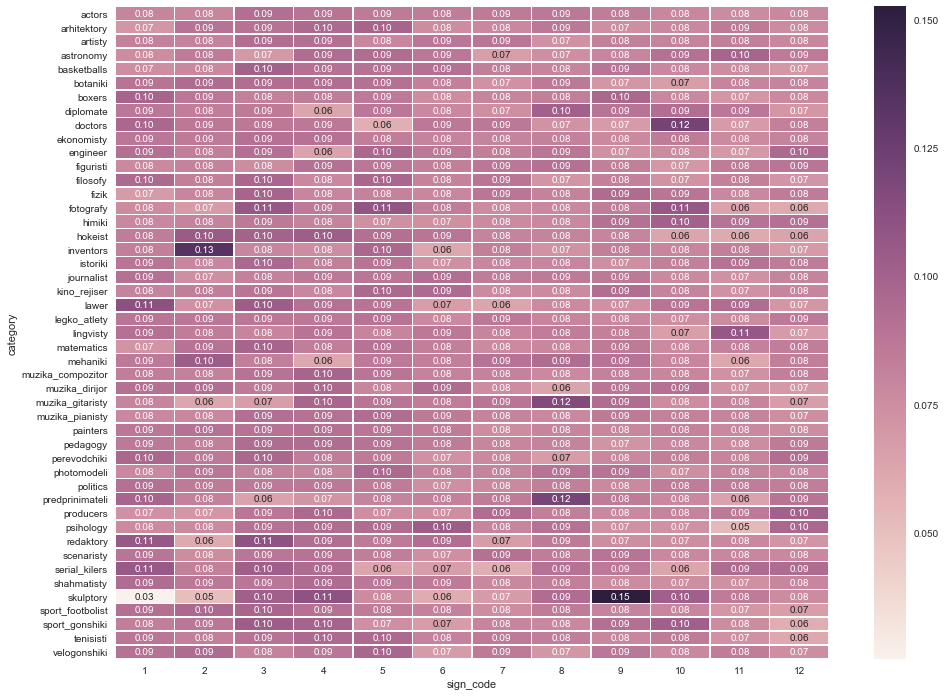

In [31]:
# Вместо этой ерунды посчитать корреляцию Крамера
# из-за того что категории не сбалансированы, график не информативен для всех категорий
plt.figure(figsize=(16, 12))
sns.heatmap(pd.crosstab(data['category'], data['sign_code'], normalize='index'), annot=True, fmt='.2f', linewidths=.5);

In [ ]:
group_sport = ['sport_footbolist', 'hokeist',  'basketballs']
ind_sport = ['legko_atlety', 'boxers', 'tenisisti', 'figuristi', 'velogonshiki', 'sport_gonshiki']

In [147]:
data.category.value_counts()

sport_footbolist     31249
actors                9938
painters              7965
politics              5997
muzika_compozitor     5118
hokeist               4286
muzika_pianisty       3698
shahmatisty           3388
legko_atlety          3139
pedagogy              3002
basketballs           2912
journalist            2473
boxers                2281
scenaristy            2184
botaniki              2034
istoriki              2005
ekonomisty            1867
artisty               1649
tenisisti             1609
arhitektory           1479
matematics            1405
photomodeli           1223
perevodchiki          1219
figuristi             1192
fizik                 1158
filosofy              1081
velogonshiki          1019
kino_rejiser          1005
sport_gonshiki         917
diplomate              873
astronomy              780
producers              707
predprinimateli        683
himiki                 637
muzika_dirijor         593
engineer               589
fotografy              498
l

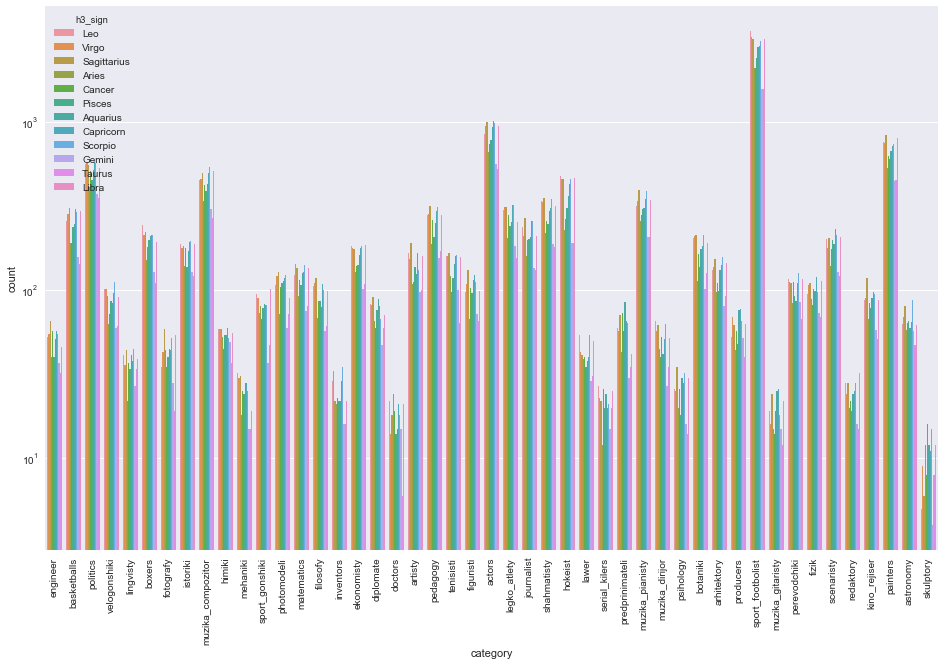

In [133]:
plt.figure(figsize=(16, 10))
sns.countplot(x='category', hue='h3_sign', data=data);
plt.xticks(rotation=90);
plt.yscale('log')

In [19]:
# plt.figure(figsize=(20, 14))
# sns.countplot(x='sign_code', hue='category', data=data[data['category'] == 'diplomate']);
# plt.xticks(rotation=90);
# plt.tick_params(axis='both', which='major', labelsize=16);

In [20]:
# plt.figure(figsize=(20, 14))
# sns.boxplot(x='category', y='h2_signlon', hue='h2_sign', data=data[data['category'] == 'инженеры']);
# plt.xticks(rotation=90);
# plt.tick_params(axis='both', which='major', labelsize=16);

In [21]:
# plt.figure(figsize=(20, 14))
# sns.boxplot(x='h3_sign', y='h3_size', hue='category', data=data);
# plt.xticks(rotation=90);
# plt.tick_params(axis='both', which='major', labelsize=16);

In [22]:
# sns.distplot(data['h12_size'])

In [25]:
# tsne = TSNE(random_state=0)
# tsne.fit(X_data)
# x = lambda x: ['red' if i == 0 else 'green' if i== 1 else 'blue' if i == 2 else 'black' \
#                if i == 3 else 'yellow' for i in x]
# color = x(y_data)
# plt.figure(figsize=(20, 14))
# plt.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1], c=color, s=200);

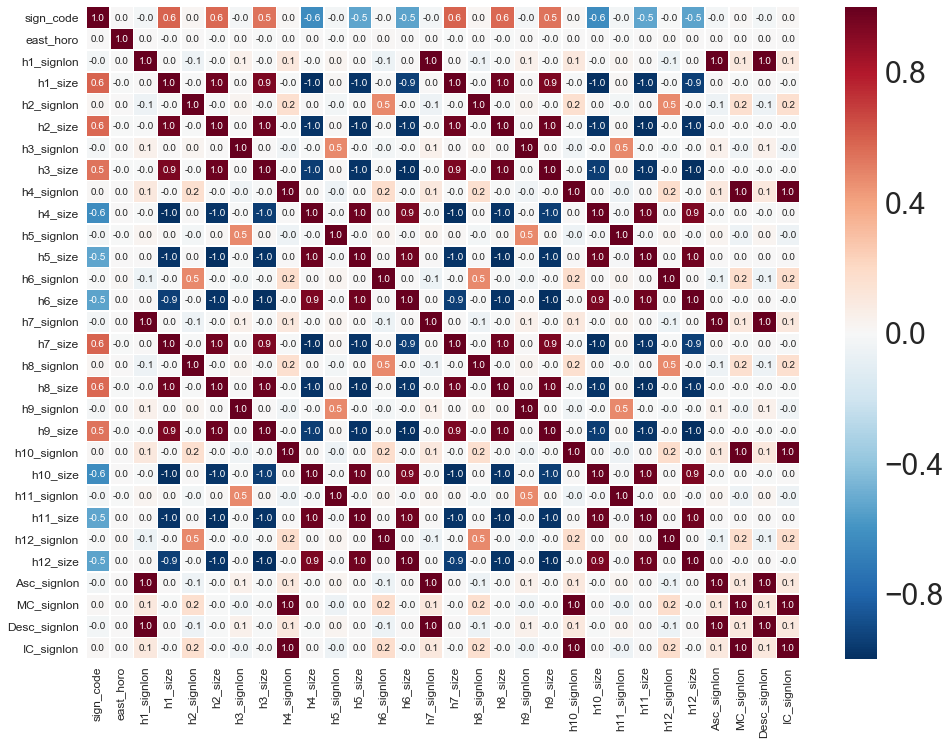

In [48]:
plt.figure(figsize=(16,12));
sns.heatmap(data.corr(), annot=True, fmt='.1f', linewidths=.5);
plt.tick_params(axis='both', which='major', labelsize=12);

# Classification

In [36]:
x_data = data.drop(labels=category_mask, axis=1)

In [40]:
x_data.head(2)

,category,h1_sign,h1_signlon,h1_size,h2_sign,h2_signlon,h2_size,h3_sign,h3_signlon,h3_size,...,h12_signlon,h12_size,Asc_sign,Asc_signlon,MC_sign,MC_signlon,Desc_sign,Desc_signlon,IC_sign,IC_signlon
index,,,,,,,,,,,,,,,,,,,,,
0,engineer,Cancer,7.979613,15.820846,Cancer,23.800458,16.415982,Leo,10.216440,17.241698,...,27.938537,40.041075,Cancer,7.979613,Aquarius,27.458139,Capricorn,7.979613,Leo,27.458139
1,engineer,Leo,9.068071,20.841177,Leo,29.909248,21.930567,Virgo,21.839814,22.292939,...,1.839079,37.228992,Leo,9.068071,Aries,14.132753,Aquarius,9.068071,Libra,14.132753


In [41]:
# подготовить данные для классификации
# x_data = x_data.drop(labels=['sign_code', 'east_horo'], axis=1)
y_data, index = pd.factorize(data['category'])
mask_sign = mask_sign + ['category']

In [43]:
x_data = pd.concat([x_data, pd.get_dummies(x_data['h1_sign'], prefix='h1_sign'),
                               pd.get_dummies(x_data['h2_sign'], prefix='h2_sign'),
                               pd.get_dummies(x_data['h3_sign'], prefix='h3_sign'),
                               pd.get_dummies(x_data['h4_sign'], prefix='h4_sign'),
                               pd.get_dummies(x_data['h5_sign'], prefix='h5_sign'),
                               pd.get_dummies(x_data['h6_sign'], prefix='h6_sign'),
                               pd.get_dummies(x_data['h7_sign'], prefix='h7_sign'),
                               pd.get_dummies(x_data['h8_sign'], prefix='h8_sign'),
                               pd.get_dummies(x_data['h9_sign'], prefix='h9_sign'),
                               pd.get_dummies(x_data['h10_sign'], prefix='h10_sign'),
                               pd.get_dummies(x_data['h11_sign'], prefix='h11_sign'),
                               pd.get_dummies(x_data['h12_sign'], prefix='h12_sign'), 
                               pd.get_dummies(x_data['Asc_sign'], prefix='Asc_sign'),
                               pd.get_dummies(x_data['MC_sign'], prefix='MC_sign'),
                               pd.get_dummies(x_data['Desc_sign'], prefix='Desc_sign'),
                               pd.get_dummies(x_data['IC_sign'], prefix='IC_sign')],
                                axis=1)

x_data.drop(labels=x_data[mask_sign], axis=1, inplace=True)
x_data.head(1)

,h1_signlon,h1_size,h2_signlon,h2_size,h3_signlon,h3_size,h4_signlon,h4_size,h5_signlon,h5_size,...,IC_sign_Cancer,IC_sign_Capricorn,IC_sign_Gemini,IC_sign_Leo,IC_sign_Libra,IC_sign_Pisces,IC_sign_Sagittarius,IC_sign_Scorpio,IC_sign_Taurus,IC_sign_Virgo
index,,,,,,,,,,,,,,,,,,,,,
0,7.979613,15.820846,23.800458,16.415982,10.21644,17.241698,27.458139,46.306461,13.7646,44.173938,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# найти признаки наиболее влияющие на целевой признак, для того чтобы уменьщить размерность

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Пробуем простое дерево

In [57]:
tree = DecisionTreeClassifier(random_state=10, max_depth=5)
tree.fit(x_data, y_data)
print('Средняя доля правильных ответом - %f' % np.mean(cross_val_score(tree, x_data, y_data, cv=5,  verbose=1)))
print('При это случайная вероятность отгодать правильный ответ - %f' % (1 / len(data['category'].unique())))

Средняя доля правильных ответом - 0.270192
При это случайная вероятность отгодать правильный ответ - 0.022727


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.8s finished


# Попробуем лес

In [64]:
forest = RandomForestClassifier(n_estimators=50, random_state=0)
forest.fit(x_data, y_data)
# вытянем значение важности признаков
importances = forest.feature_importances_
importance_indexes = np.argsort(importances)[::-1]
print('Средняя доля правильных ответом - %f' % np.mean(cross_val_score(forest, x_data, y_data, cv=5,  verbose=1)))
print('При это случайная вероятность отгодать правильный ответ - %f' % (1 / len(data['category'].unique())))

Средняя доля правильных ответом - 0.182432
При это случайная вероятность отгодать правильный ответ - 0.027778


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.5min finished


# Пробуем кросс-валидацию параметров леса

In [ ]:
tree_params = {'max_depth' : [3, 4, 5, 6, 10, 15],
              'max_features' : [4, 5, 6, 7]}
greed_tree = GridSearchCV(tree, tree_params, cv=5)
greed_tree.fit(x_data[valuable_features], y_data)
greed_tree.best_score_, greed_tree.best_params_

# Попробуем объеденить категории професей (обобщить ить)

In [ ]:
mask = data[data['category'].isin(['doctors', 'serial_kilers', 'psihology', 'east_horo'])].index
data.drop(mask, inplace=True)

In [62]:
# уменьшить размерность вектора професий (обобщить)
sport = ['hokeist', 'legko_atlety', 'basketballs', 'boxers', 'tenisisti', 'figuristi', 'velogonshiki',
        'sport_gonshiki', 'sport_footbolist']
# muzika = ['muzika_pevcy', 'muzika_pianisty', 'muzika_gitaristy', 'muzika_dirijor']
# pisaki = ['scenaristy', 'kino_rejiser', 'redaktory', 'journalist']
# iskustvo = ['painters', 'muzika_compozitor', 'arhitektory', 'skulptory', 'fotografy']
# artisy = ['actors', 'artisty']
# raschet = ['shahmatisty', 'ekonomisty', 'matematics', 'fizik', 'astronomy', 'himiki']
# engineer = ['engineer', 'inventors', 'mehaniki']
# filology = ['lingvisty', 'istoriki', 'pedagogy']
# organizatory = ['predprinimateli', 'producers']

x_data.loc[x_data['category'].isin(sport), 'category'] = 'спорсмены'
# data.loc[data['category'].isin(muzika), 'category'] = 'музыка'
# data.loc[data['category'].isin(pisaki), 'category'] = 'писаки'
# data.loc[data['category'].isin(iskustvo), 'category'] = 'искуство'
# data.loc[data['category'].isin(artisy), 'category'] = 'выбражалы'
# data.loc[data['category'].isin(raschet), 'category'] = 'точные_науки'
# data.loc[data['category'].isin(engineer), 'category'] = 'инженеры'
# data.loc[data['category'].isin(filology), 'category'] = 'филологи'
# data.loc[data['category'].isin(organizatory), 'category'] = 'предприниматели'

In [ ]:
tree = DecisionTreeClassifier(random_state=10, max_depth=5)
tree.fit(x_data, y_data)
print('Средняя доля правильных ответом - %f' % np.mean(cross_val_score(tree, x_data, y_data, cv=5,  verbose=1)))
print('При это случайная вероятность отгодать правильный ответ - %f' % (1 / len(data['category'].unique())))

In [62]:
%%time
forest = RandomForestClassifier(n_estimators=10, random_state=0)
forest.fit(x_data, y_data)
importances = forest.feature_importances_

# отсортировать признаки по важности
indexes = np.argsort(importances)[::-1]

CPU times: user 16 s, sys: 500 ms, total: 16.5 s
Wall time: 16.8 s


In [97]:
features_importance = pd.DataFrame(list(zip(x_data.columns[indexes], importances[indexes])), 
                                   columns=['name', 'importance'])
plt.bar(left=np.arange(features_importance.shape[0]), height=features_importance['importance']);
plt.xlim([0, 30])

# по графику видим что значимые первые 30 признаков
valuable_features = x_data.columns[indexes[:30]]
unvaluable_features = x_data.columns[indexes[30:]]

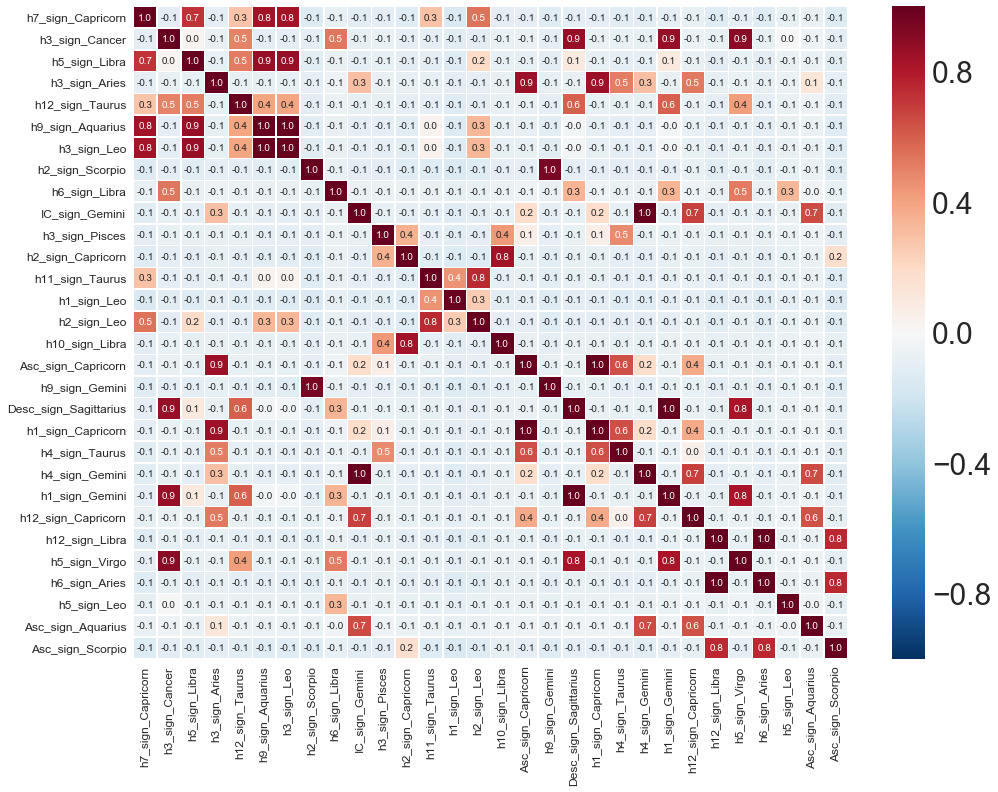

In [123]:
plt.figure(figsize=(16,12));
sns.heatmap(x_data[unvaluable_features[:30]].corr(method='spearman'), annot=True, fmt='.1f', linewidths=.5)
plt.tick_params(axis='both', which='major', labelsize=12);

In [134]:
# стартифицированная кросс-валидация, результат тот же
# kfold = StratifiedKFold(n_splits=5)
# kfold.get_n_splits(x_data, y_data)
# x_data['index'] = range(x_data.shape[0])
# x_data.set_index('index', inplace=True)
# tree = DecisionTreeClassifier(random_state=10, max_depth=5)
# for train_index, test_index in kfold.split(x_data, y_data):
#     tree.fit(x_data.loc[train_index], y_data[train_index])
#     print(tree.score(x_data.loc[test_index], y_data[test_index]))